In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
from glob import glob

# Enable inline plotting for Jupyter Lab
%matplotlib inline

# Standard column names for output DataFrame
standard_columns = [
    'Site_Id', 'Date', 'Time', 'PREC', 'TOBS', 'STO_2', 'STO_4', 'STO_8',
    'STO_20', 'STO_40', 'STO_80', 'BATT', 'STV_4', 'SRAD', 'ETIL', 'ETIB'
]

# Mapping of possible header variations to standard columns
header_mapping = {
    'site id': 'Site_Id',
    'site_id': 'Site_Id',
    'siteid': 'Site_Id',
    'date': 'Date',
    'time': 'Time',
    'prec.i-1 (in)': 'PREC',
    'precipitation': 'PREC',
    'tobs.i-1 (degc)': 'TOBS',
    'air_temp': 'TOBS',
    'sto.i-1:-2 (degc)': 'STO_2',
    'sto-2': 'STO_2',
    'sto.i-1:-4 (degc)': 'STO_4',
    'sto-4': 'STO_4',
    'sto.i-1:-8 (degc)': 'STO_8',
    'sto-8': 'STO_8',
    'sto.i-1:-20 (degc)': 'STO_20',
    'sto-20': 'STO_20',
    'sto.i-1:-40 (degc)': 'STO_40',
    'sto-40': 'STO_40',
    'sto.i-1:-80 (degc)': 'STO_80',
    'sto-80': 'STO_80',
    'batt.i-1 (volt)': 'BATT',
    'battery': 'BATT',
    'stv.h-1:-4 (degc)': 'STV_4',
    'stv-4': 'STV_4',
    'srad.i-1 (watt)': 'SRAD',
    'solar_radiation': 'SRAD',
    'etil.i-1 (volt)': 'ETIL',
    'etib.i-1 (volt)': 'ETIB'
}

# Load and inspect a sample CSV to confirm headers
sample_file = None
scan_data_dir = 'scan_data'
pattern = re.compile(r'2015_ALL_YEAR=(\d{4})\.csv')
for file_name in os.listdir(scan_data_dir):
    if pattern.match(file_name):
        sample_file = os.path.join(scan_data_dir, file_name)
        break

if sample_file:
    print("\nInspecting raw headers and first few rows of sample CSV:")
    sample_df = pd.read_csv(sample_file, skiprows=6, nrows=5)
    print("Raw headers:", sample_df.columns.tolist())
    print("Sample rows:\n", sample_df)

# Load all CSV files in scan_data subdirectory
df_list = []
if not os.path.exists(scan_data_dir):
    raise ValueError(f"Directory {scan_data_dir} does not exist.")

# Load CSVs
files = glob('scan_data/*.csv')
df_list = []
for file in files:
    df = pd.read_csv(file, skiprows=6, na_values=['', 'NaN', -99.9])
    df = df.loc[:, ~df.columns.str.contains('^Unnamed', na=False)]

    raw_headers = [col.lower().strip() for col in df.columns]
    # Map raw headers to standard columns
    mapped_columns = []
    for col in raw_headers:
        mapped_col = header_mapping.get(col, None)
        if mapped_col:
            mapped_columns.append(mapped_col)
        else:
            mapped_columns.append(col)  # Keep unmapped columns temporarily
    df.columns = mapped_columns

    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M', errors='coerce')
    df = df.dropna(subset=['Datetime'])
    df_list.append(df)

# Concatenate all non-empty dataframes
df = pd.concat([df for df in df_list if not df.empty], ignore_index=False)

# Filter out rows with invalid Date format (not matching YYYY-MM-DD)
valid_date_pattern = re.compile(r'^\d{4}-\d{2}-\d{2}$')
invalid_dates = df[~df['Date'].str.match(valid_date_pattern, na=False)]
if not invalid_dates.empty:
    print(f"\nFound {len(invalid_dates)} rows with invalid Date formats. Sample:")
    print(invalid_dates[['Date', 'Time', 'Site_Id']].head())
    df = df[df['Date'].str.match(valid_date_pattern, na=False)]

# Filter out rows with invalid Time format (not matching HH:MM)
valid_time_pattern = re.compile(r'^\d{2}:\d{2}$')
invalid_times = df[~df['Time'].str.match(valid_time_pattern, na=False)]
if not invalid_times.empty:
    print(f"\nFound {len(invalid_times)} rows with invalid Time formats. Sample:")
    print(invalid_times[['Date', 'Time', 'Site_Id']].head())
    df = df[df['Time'].str.match(valid_time_pattern, na=False)]

# Inspect the first few rows to verify data loading
print("\nSample Data (first 5 rows before cleaning):")
print(df.head())  # Show key columns

# Check for NaT values after parsing
nat_count = df['Datetime'].isna().sum()
if nat_count > 0:
    print(f"\nFound {nat_count} rows with unparseable Datetime values. Sample:")
    print(df[df['Datetime'].isna()][['Date', 'Time', 'Site_Id']].head())
    df = df.dropna(subset=['Datetime'])  # Drop rows with NaT

if df.empty:
    raise ValueError("No valid datetime rows remain after cleaning. Check CSV files for correct Date/Time formats.")

# Check for duplicate Datetime entries
duplicates = df[df['Datetime'].duplicated(keep=False)]
if not duplicates.empty:
    print(f"\nFound {len(duplicates)} duplicate Datetime entries. Sample:")
    print(duplicates[['Datetime', 'Site_Id', 'TOBS', 'PREC']].head())
    print("Dropping duplicates, keeping first occurrence...")
    df = df.drop_duplicates(subset='Datetime', keep='first')

# Set Datetime as index
df = df.set_index('Datetime')
df = df.drop(['Date', 'Time'], axis=1)  # Drop original date/time columns

# Replace missing values (-99.9) with NaN
df = df.replace(-99.9, np.nan)

# Ensure numeric types
numeric_cols = [col for col in df.columns if col != 'Site_Id']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Basic summary statistics
print("\nDataset Summary:")
print(df.describe())


Inspecting raw headers and first few rows of sample CSV:
Raw headers: ['Site Id', 'Date', 'Time', 'PREC.I-1 (in) ', 'TOBS.I-1 (degC) ', 'STO.I-1:-2 (degC) ', 'STO.I-1:-4 (degC) ', 'STO.I-1:-8 (degC) ', 'STO.I-1:-20 (degC) ', 'STO.I-1:-40 (degC) ', 'STO.I-1:-80 (degC) ', 'BATT.I-1 (volt) ', 'STV.H-1:-4 (degC) ', 'SRAD.I-1 (watt) ', 'ETIL.I-1 (volt) ', 'ETIB.I-1 (volt) ', 'Unnamed: 16']
Sample rows:
    Site Id        Date   Time  PREC.I-1 (in)   TOBS.I-1 (degC)   \
0     2015  1994-10-01  00:00             0.0              15.5   
1     2015  1994-10-01  06:00             0.0              12.3   
2     2015  1994-10-01  12:00             0.0              20.5   
3     2015  1994-10-01  18:00             0.0              12.4   
4     2015  1994-10-02  00:00             0.0              13.6   

   STO.I-1:-2 (degC)   STO.I-1:-4 (degC)   STO.I-1:-8 (degC)   \
0               -99.9               -99.9               -99.9   
1               -99.9               -99.9               -99.9   


Displaying: Monthly Average Air Temperature by Year


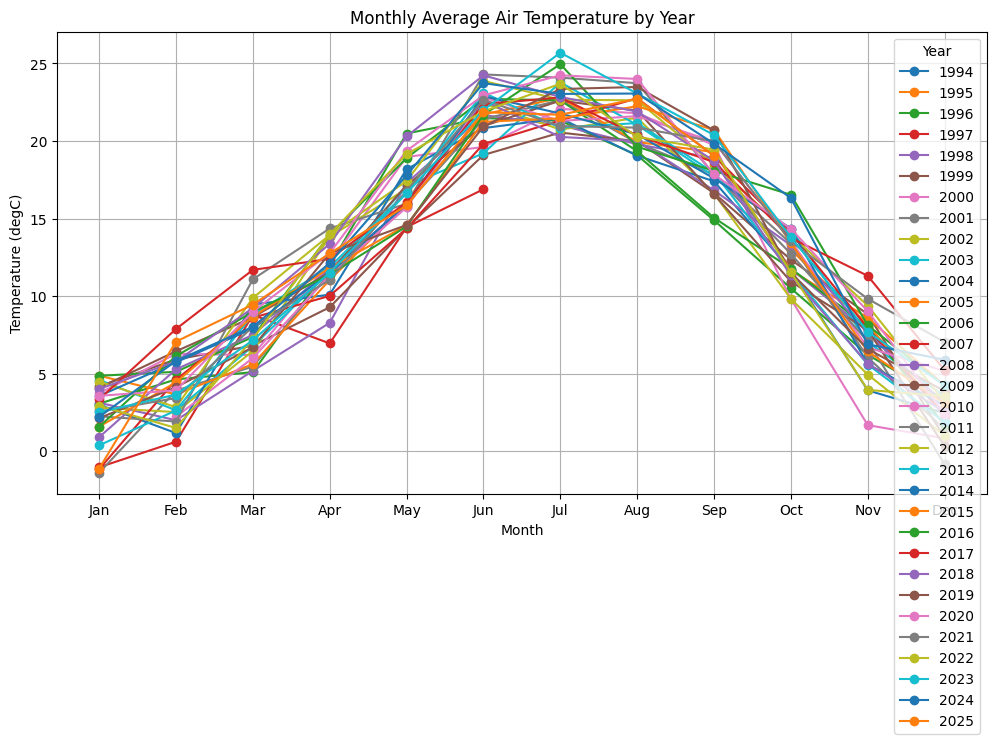

In [9]:
# New Plot: Monthly average TOBS for each year
print("\nDisplaying: Monthly Average Air Temperature by Year")
# Group by year and month, compute mean TOBS
df['Year'] = df.index.year
df['Month'] = df.index.month
monthly_avg = df.groupby(['Year', 'Month'])['TOBS'].mean().unstack(level=0)
# Plot each year as a line
plt.figure(figsize=(12, 6))
for year in monthly_avg.columns:
    plt.plot(monthly_avg.index, monthly_avg[year], label=f'{year}', marker='o')
plt.title('Monthly Average Air Temperature by Year')
plt.xlabel('Month')
plt.ylabel('Temperature (degC)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.show()
#print("\nMonthly Average TOBS by Year:")
#print(monthly_avg)


Displaying: Daily Average Air Temperature by Year


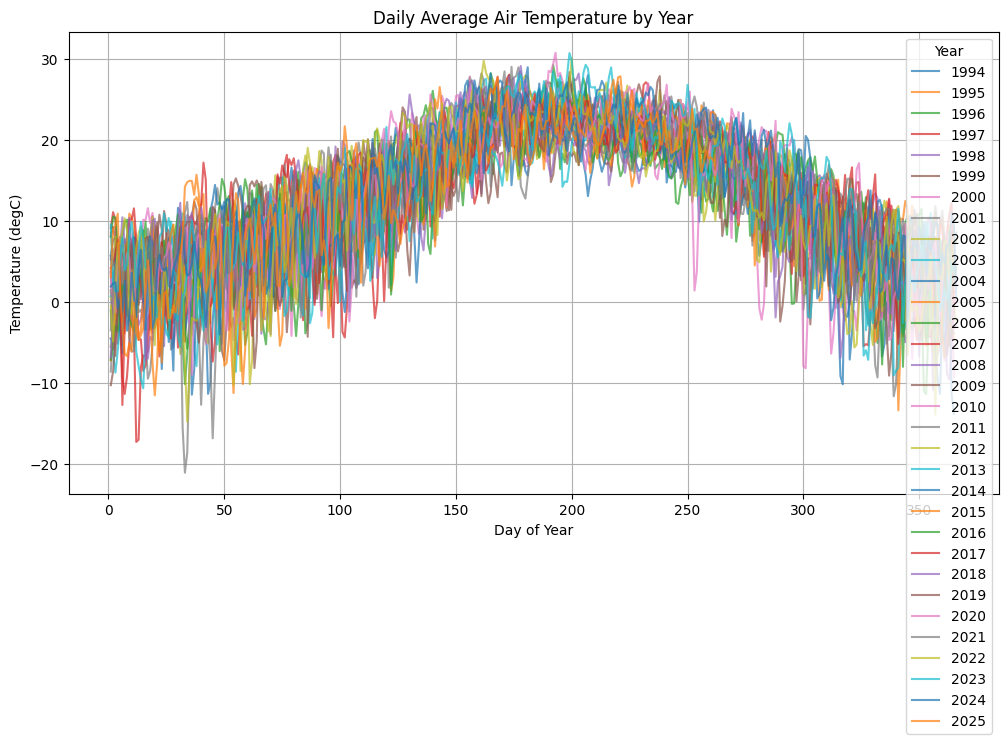

In [12]:
# New Plot: Daily average TOBS for each year
print("\nDisplaying: Daily Average Air Temperature by Year")
df['DayOfYear'] = df.index.dayofyear
daily_avg = df.groupby(['Year', 'DayOfYear'])['TOBS'].mean().unstack(level=0)
plt.figure(figsize=(12, 6))
for year in daily_avg.columns:
    plt.plot(daily_avg.index, daily_avg[year], label=f'{year}', alpha=0.7)
plt.title('Daily Average Air Temperature by Year')
plt.xlabel('Day of Year')
plt.ylabel('Temperature (degC)')
plt.legend(title='Year')
plt.grid(True)
plt.show()


Displaying: Monthly Average Soil Temperature at 4cm by Year


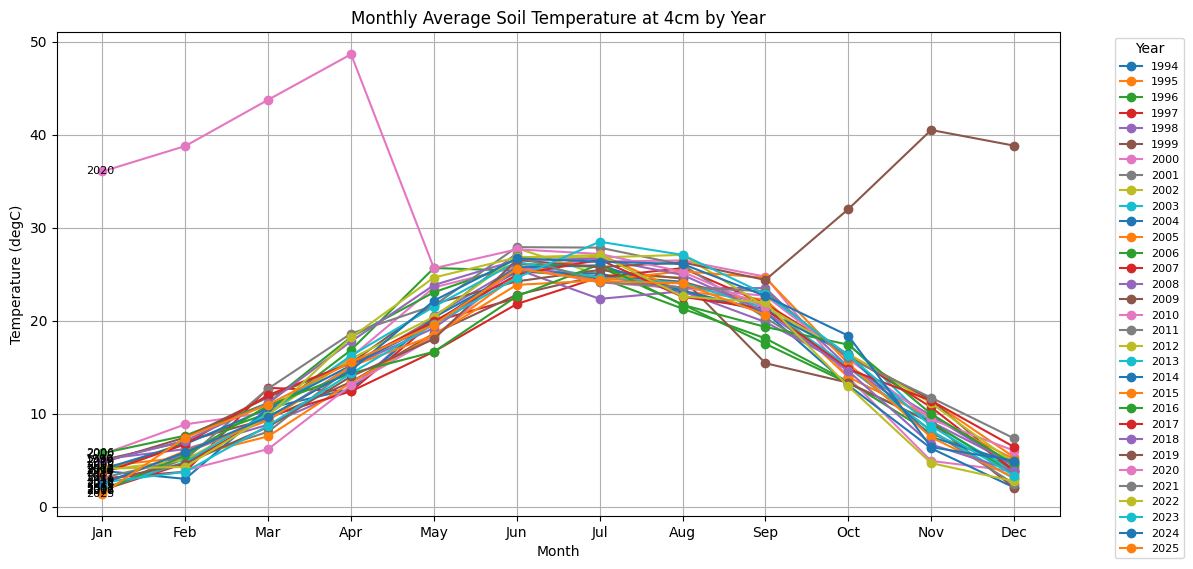

In [17]:
# New Plot: Monthly average STO_4 for each year
if 'STO_4' in df.columns:
    print("\nDisplaying: Monthly Average Soil Temperature at 4cm by Year")
    # Group by year and month, compute mean STO_4
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    monthly_avg = df.groupby(['Year', 'Month'])['STO_4'].mean().unstack(level=0)
    # Plot each year as a line with year labels at start
    plt.figure(figsize=(12, 6))
    for year in monthly_avg.columns:
        plt.plot(monthly_avg.index, monthly_avg[year], label=f'{year}', marker='o')
        # Add year label at Month 1 (January)
        if not np.isnan(monthly_avg[year].loc[1]):  # Check if January data exists
            plt.text(0.8, monthly_avg[year].loc[1], str(year), fontsize=8, verticalalignment='center')
    plt.title('Monthly Average Soil Temperature at 4cm by Year')
    plt.xlabel('Month')
    plt.ylabel('Temperature (degC)')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(title='Year', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nWarning: STO_4 column (soil temperature at 4cm) not available in the dataset. Check if the CSV files include STO.I-1:-4 (degC) or similar.")



Displaying: Annual Average Air Temperature


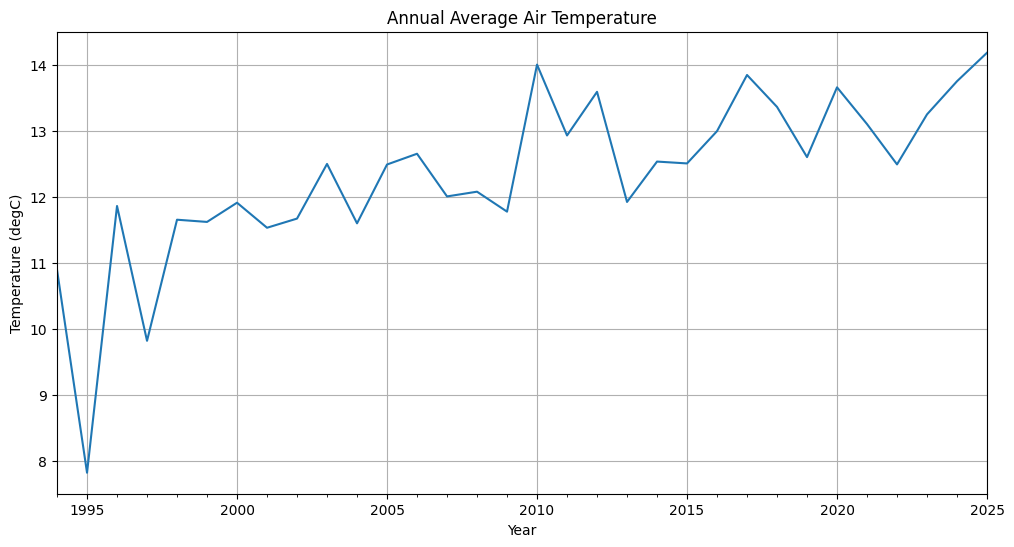

In [3]:
# 1. Long-term trend: Annual average air temperature (TOBS) to check for warming
print("\nDisplaying: Annual Average Air Temperature")
annual_avg = df['TOBS'].resample('YE').mean()  # Year-end resampling
plt.figure(figsize=(12, 6))
annual_avg.plot(title='Annual Average Air Temperature')
plt.ylabel('Temperature (degC)')
plt.xlabel('Year')
plt.grid(True)
plt.show()


Displaying: Seasonal Air Temperature Patterns


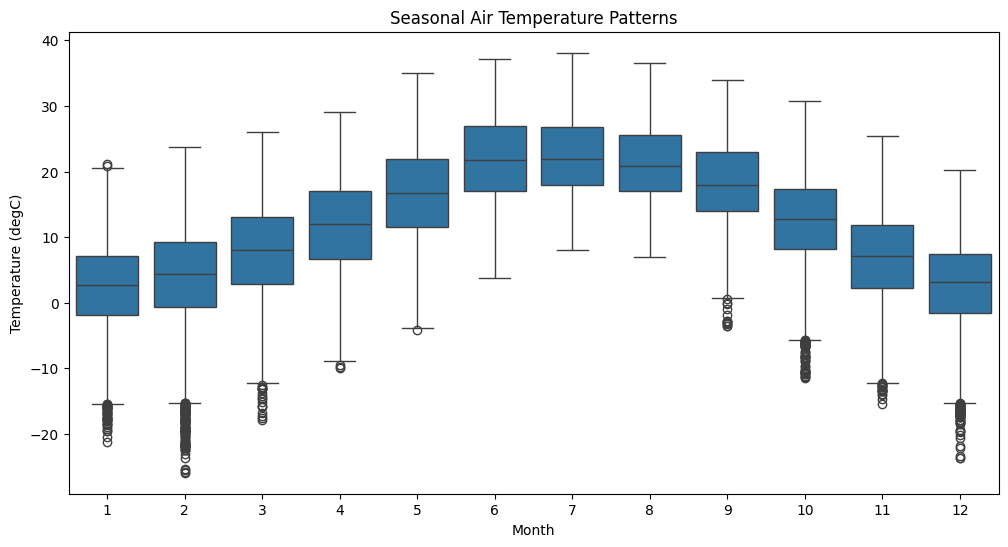


Displaying: Seasonal Precipitation Patterns


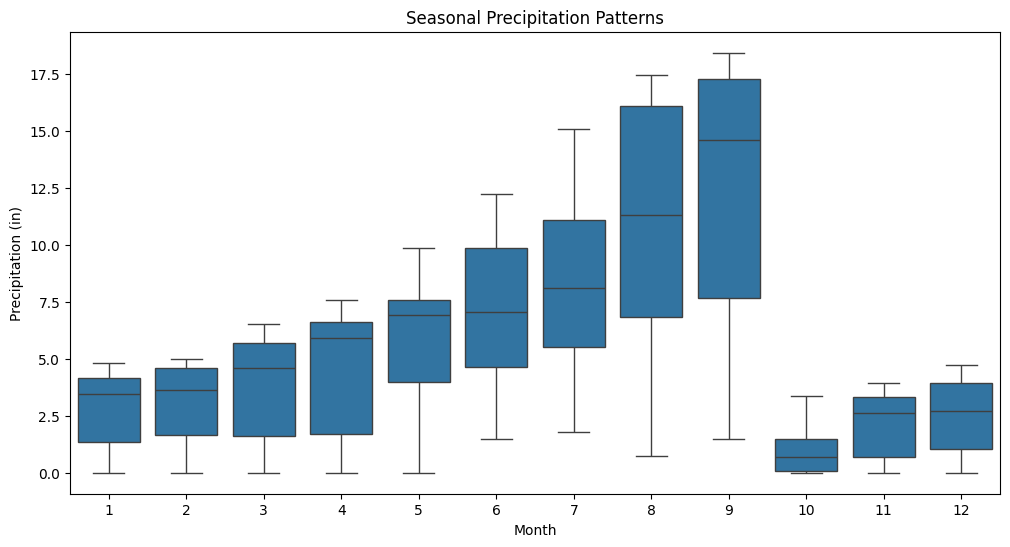


Displaying: Seasonal Solar Radiation Patterns


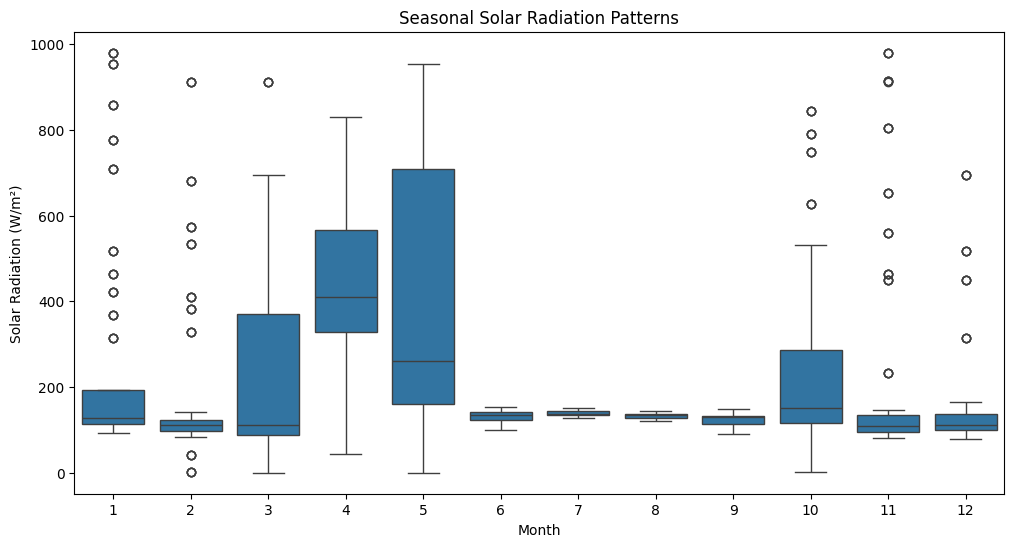

In [4]:
# 2. Seasonal patterns: Monthly boxplots for key variables
df['Month'] = df.index.month
print("\nDisplaying: Seasonal Air Temperature Patterns")
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='TOBS', data=df)
plt.title('Seasonal Air Temperature Patterns')
plt.ylabel('Temperature (degC)')
plt.show()

print("\nDisplaying: Seasonal Precipitation Patterns")
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='PREC', data=df)
plt.title('Seasonal Precipitation Patterns')
plt.ylabel('Precipitation (in)')
plt.show()

print("\nDisplaying: Seasonal Solar Radiation Patterns")
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='SRAD', data=df)
plt.title('Seasonal Solar Radiation Patterns')
plt.ylabel('Solar Radiation (W/m²)')
plt.show()




Displaying: Correlation Matrix


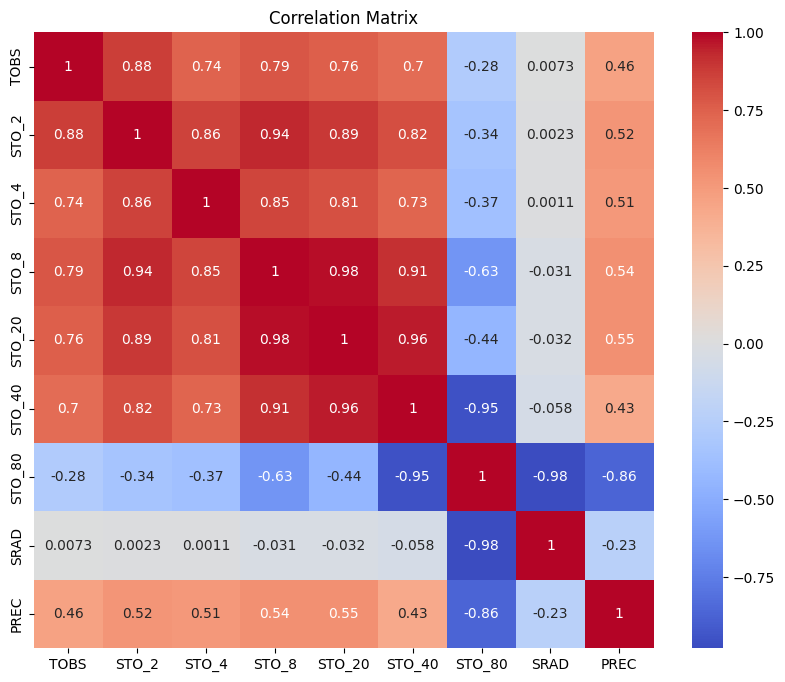


Key Correlations (TOBS with other variables):
TOBS      1.000000
STO_2     0.875827
STO_8     0.785726
STO_20    0.759265
STO_4     0.740606
STO_40    0.700674
PREC      0.462363
SRAD      0.007332
STO_80   -0.277064
Name: TOBS, dtype: float64


In [5]:
# 3. Correlations: Between air temp, soil temps, and other variables
print("\nDisplaying: Correlation Matrix")
corr_matrix = df[['TOBS', 'STO_2', 'STO_4', 'STO_8', 'STO_20', 'STO_40', 'STO_80', 'SRAD', 'PREC']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
print("\nKey Correlations (TOBS with other variables):")
print(corr_matrix['TOBS'].sort_values(ascending=False))




Displaying: Annual Precipitation Totals


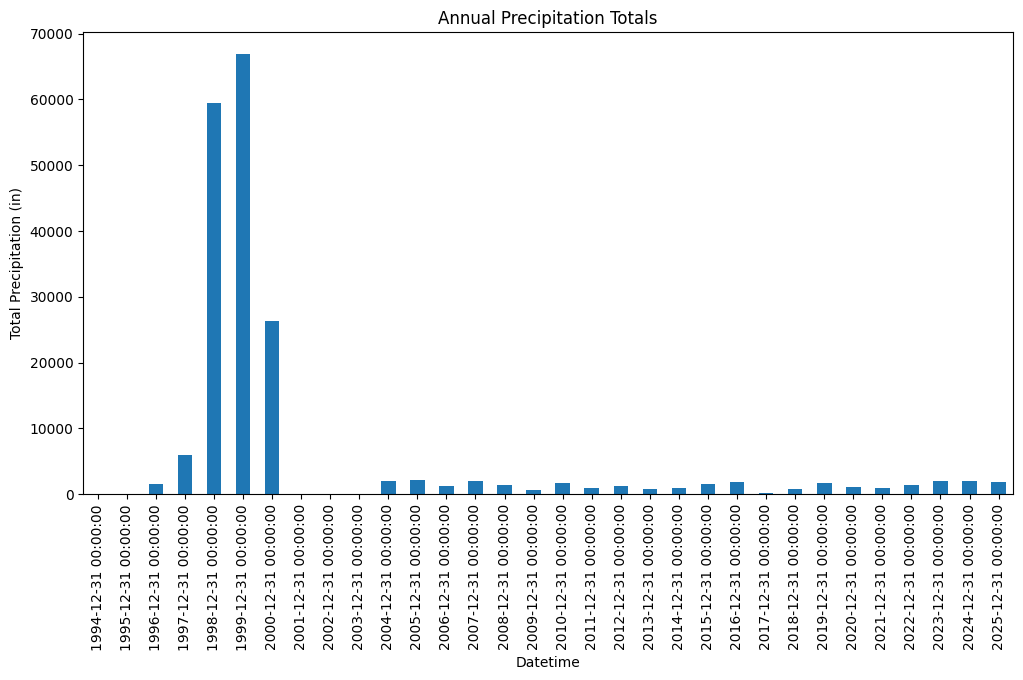

In [6]:
# 4. Yearly precipitation totals
print("\nDisplaying: Annual Precipitation Totals")
annual_precip = df['PREC'].resample('YE').sum()  # Year-end resampling
plt.figure(figsize=(12, 6))
annual_precip.plot(kind='bar', title='Annual Precipitation Totals')
plt.ylabel('Total Precipitation (in)')
plt.show()




Displaying: 2025 Temperature Profiles: Air vs. Soil Depths (Daily Means)


<Figure size 1200x600 with 0 Axes>

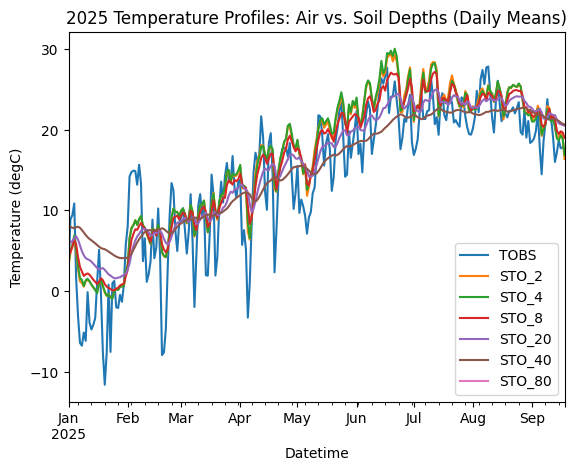

In [7]:
# 5. Soil temperature profiles over depths (last full year in dataset)
last_year = df.index.year.max()
sample_year = df[df.index.year == last_year].resample('D').mean()  # Use boolean mask to select year
if sample_year.empty:
    print(f"\nWarning: No data available for year {last_year}. Skipping soil temperature plot.")
else:
    print(f"\nDisplaying: {last_year} Temperature Profiles: Air vs. Soil Depths (Daily Means)")
    plt.figure(figsize=(12, 6))
    sample_year[['TOBS', 'STO_2', 'STO_4', 'STO_8', 'STO_20', 'STO_40', 'STO_80']].plot()
    plt.title(f'{last_year} Temperature Profiles: Air vs. Soil Depths (Daily Means)')
    plt.ylabel('Temperature (degC)')
    plt.show()




Displaying: Battery Voltage Over Time (Monthly Means)


C:\Users\HP\AppData\Local\Temp\ipykernel_13964\3587327285.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['BATT'].resample('M').mean().plot(title='Battery Voltage Over Time (Monthly Means)')


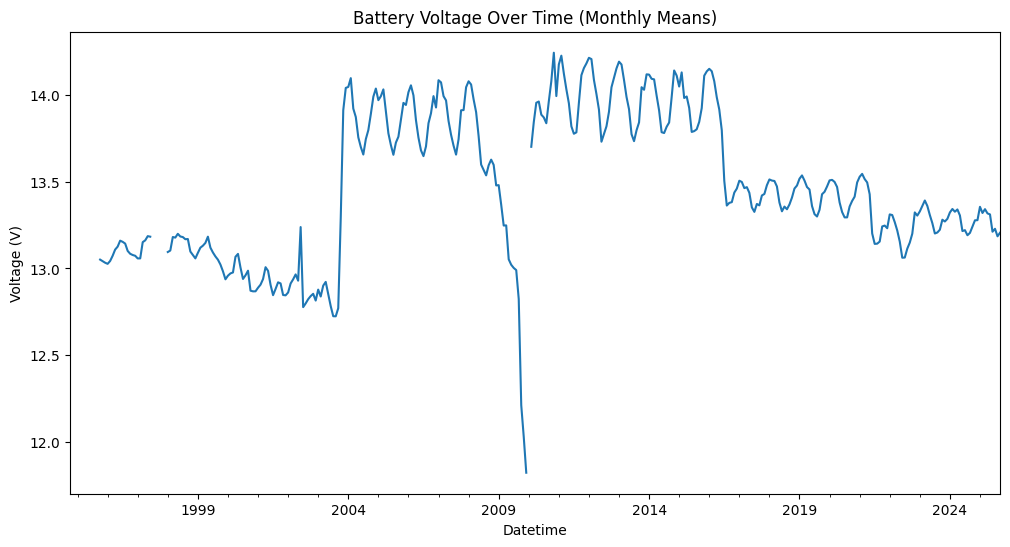

In [8]:
# 6. Battery voltage stability (monthly means for performance)
print("\nDisplaying: Battery Voltage Over Time (Monthly Means)")
plt.figure(figsize=(12, 6))
df['BATT'].resample('M').mean().plot(title='Battery Voltage Over Time (Monthly Means)')
plt.ylabel('Voltage (V)')
plt.show()